In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn import pipeline
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn import svm, datasets
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve


import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
stopwords_nltk = nltk.corpus.stopwords.words('portuguese')

import matplotlib.pyplot as  plt
%matplotlib inline
plt.style.use('bmh')

import graphviz
import os
os.environ['PATH'] = os.environ['PATH'] + ';C:/Program Files (x86)/Graphviz2.38/bin'


datapath = '../../Data/Processed/manut_eqprede_treino.parquet'

O arquivo parquet utilizado aqui é um subconjunto dos registros analisados, pois a quantidade de registros utilizados no original e a capacidade de processamento da máquina onde foram rodados os modelos, eram limitadas e não atenderam o tarefa.

### **<span style="color:MediumSlateBlue">0. Novas palavras para o Stopwords</span>**

In [2]:
stopwords_nltk.append('equipe')
stopwords_nltk.append('kv')
stopwords_nltk.append('mw')
stopwords_nltk.append('quente')
stopwords_nltk.append('ponto')
stopwords_nltk.append('230')
stopwords_nltk.append('nº')
stopwords_nltk.append('comando')
stopwords_nltk.append('contatos')
stopwords_nltk.append('sistema')
stopwords_nltk.append('realizar')
stopwords_nltk.append('novo')
stopwords_nltk.append('01')
stopwords_nltk.append('10')
stopwords_nltk.append('02')
stopwords_nltk.append('03')
stopwords_nltk.append('13')
stopwords_nltk.append('08')
stopwords_nltk.append('equipamentos')
stopwords_nltk.append('pm04')
stopwords_nltk.append('st6')
stopwords_nltk.append('nova')
stopwords_nltk.append('ii')
stopwords_nltk.append('ons')

### **<span style="color:MediumSlateBlue"> 1.Carga dos Dados </span>**

In [3]:
dataframe = pd.read_parquet(datapath)

print('shape:', dataframe.shape)
print('columns:', dataframe.columns)

shape: (8696, 2)
columns: Index(['CLASSE', 'TEXTO'], dtype='object')


### <span style="color:MediumSlateBlue"> **2. Treino / Teste** </span>

In [4]:
X = dataframe['TEXTO'].values.reshape(-1).tolist()
Y = (dataframe['CLASSE'].values.reshape(-1) == 'POS').tolist()

# Dividir 20% dos dados para o conjunto out-of-sample de teste
Xtrain, Xtest, Ytrain, Ytest = model_selection.train_test_split( X,
                                                                 Y,
                                                                 test_size=0.2,
                                                                 random_state=0,
                                                                 stratify= Y 
                                                                 )

# Xtrain e Xtest = Texto
# Ytrain e Ytest = Classe

In [5]:
# Objeto de validacao cruzada
cvfold = model_selection.StratifiedKFold(n_splits = 5, random_state = 0, shuffle = True, )
#, shuffle = False)

print("KFold")
for train_index, test_index in cvfold.split(Xtrain, Ytrain):
    print("TRAIN:", train_index, "TEST:", test_index)

KFold
TRAIN: [   0    2    3 ... 6952 6953 6954] TEST: [   1    4    9 ... 6941 6946 6955]
TRAIN: [   0    1    2 ... 6953 6954 6955] TEST: [   6    8   12 ... 6943 6948 6949]
TRAIN: [   0    1    3 ... 6952 6954 6955] TEST: [   2    5   16 ... 6945 6951 6953]
TRAIN: [   0    1    2 ... 6951 6953 6955] TEST: [  21   25   37 ... 6928 6952 6954]
TRAIN: [   1    2    4 ... 6953 6954 6955] TEST: [   0    3    7 ... 6944 6947 6950]


### <span style="color:MediumSlateBlue"> **3.Construção do Pipeline** </span>

In [6]:
# Configure Pipeline
model_dict = {
    'RandomForest': ensemble.RandomForestClassifier(n_estimators=10, max_features='sqrt'),
    'LogisticRegr': LogisticRegression(),
    'kNN': KNeighborsClassifier(weights='distance'),
    'SVM': SVC(probability=False, gamma='auto'),
}

model_conf = {
 'RandomForest': {
 'Model__max_depth': [4, 6],
 'Model__n_estimators': [10, 50], 
    },
    'LogisticRegr': {
        'Model__C': [0.001, 0.1, 1, 10],
    },
    'kNN': {
        'Model__n_neighbors': [5, 10, 20],
    },
    'SVM': {
        'Model__kernel': ['rbf',],
        'Model__C' : [0.1, 1, 10],
    }
}

scorer = metrics.make_scorer(metrics.f1_score)   
            

In [7]:
model_list = {}


for model_name in model_dict.keys():
    conf_train_pipe = [
        ('TfIDf', TfidfVectorizer(Xtrain,stop_words=stopwords_nltk)),
        ('Model', model_dict[model_name]),
    ]
    
    #cross_val_score
    # Create Pipeline
    model_pipe = pipeline.Pipeline(conf_train_pipe)
    param_grid = model_conf[model_name].copy()
    model_pipe = model_selection.GridSearchCV(model_pipe, param_grid,
                                              scoring=scorer,
                                              n_jobs=1,
                                              cv=cvfold,
                                              return_train_score = True,)
    
    

    model_pipe.fit(Xtrain, Ytrain)
    model_list[model_name] = model_pipe 

### <span style="color:MediumSlateBlue"> **4. Curva ROC** </span>

Text(0, 0.5, 'Taxa de Detecção')

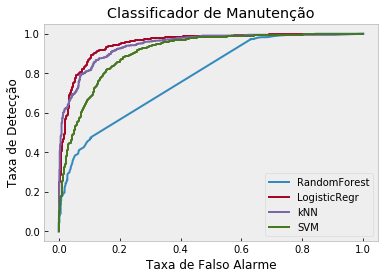

In [8]:
plt.figure(figsize=(6,4))

for model_name in model_dict.keys():
    model = model_list[model_name]
    # estimate Y
    if model_name in ['RandomForest', 'SVM']:
        final_model = LogisticRegressionCV(Cs=20,cv=5)
        if model_name == 'SVM':
            Yhat_train = model.decision_function(Xtrain)
            Yhat = model.decision_function(Xtest)
        else:
            Yhat_train = model.predict_proba(Xtrain)[:,1]
            Yhat = model.predict_proba(Xtest)[:,1]
            
        final_model.fit(Yhat_train.reshape(-1, 1), Ytrain)
        Yhat  = final_model.predict_proba(Yhat.reshape(-1,1))[:,1]
        Ypred = final_model.predict(Yhat.reshape(-1,1))
    else:
        Yhat = model.predict_proba(Xtest)[:,1]
        Ypred = model.predict(Xtest)
    
    
    fpr, tpr, thr = metrics.roc_curve(Ytest, Yhat)
    auc = metrics.roc_auc_score(Ytest, Yhat)
    f1 = metrics.f1_score(Ytest, Ypred)
    label = model_name # + " AUC: %.3f - F1: %.3f"%(auc, f1)
    plt.plot(fpr, tpr, '-', lw=2, label=label)

    
plt.legend()
plt.title('Classificador de Manutenção')
plt.grid()
plt.xlabel('Taxa de Falso Alarme')
plt.ylabel('Taxa de Detecção')

### <span style="color:MediumSlateBlue"> **5.Distribuição de Probabilidades do Modelo** </span>

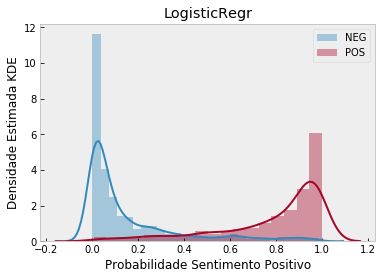

In [9]:
model_name = 'LogisticRegr'
model = model_list[model_name]
Yhat = model.predict_proba(Xtest)[:,1]

for i in [False, True]:
    # 2 Classes case
    sns.distplot(Yhat[np.array(Ytest) == i], label=['NEG','POS'][i])

plt.title(model_name)
plt.ylabel('Densidade Estimada KDE')
plt.xlabel('Probabilidade Sentimento Positivo')
plt.grid()
plt.legend()

### <span style="color:MediumSlateBlue"> **6.Matriz de Confusão** </span>

In [10]:
model_name = 'LogisticRegr'


model = model_list[model_name]
Ypred = model.predict(Xtest)

col_names = ['Model ' + s for s in ['Neg','Pos']]
idx_names = ['Real ' + s for s in ['Neg','Pos']]

cmat = metrics.confusion_matrix(Ytest, Ypred)
cmat = pd.DataFrame(cmat, index=idx_names,
                              columns=col_names)
cmat['Real Total'] = cmat.sum(axis=1)
cmat.loc['Model Total',:] = cmat.sum(axis=0)
cmat = cmat.astype(int)
cmat


,Model Neg,Model Pos,Real Total
Real Neg,900,96,996
Real Pos,103,641,744
Model Total,1003,737,1740


In [11]:
print(metrics.classification_report(Ytest, Ypred))

              precision    recall  f1-score   support

       False       0.90      0.90      0.90       996
        True       0.87      0.86      0.87       744

    accuracy                           0.89      1740
   macro avg       0.88      0.88      0.88      1740
weighted avg       0.89      0.89      0.89      1740



### <span style="color:MediumSlateBlue"> **7.Coeficientes de Regressão** </span>

Text(0.5, 0, 'Coeficiente')

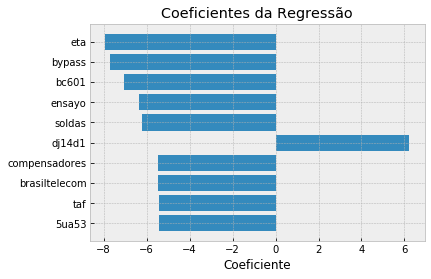

In [12]:
plt.figure(figsize=(6,4))

nshow = 10
model_name = 'LogisticRegr'
model = model_list[model_name].best_estimator_.steps[1][1]
vocabulary = model_list[model_name].best_estimator_.steps[0][1].vocabulary_
vocabulary = np.array(list(vocabulary.keys()))

coefs = model.coef_[0]

idx = np.argsort(np.abs(coefs))[-nshow:]

yaxis = np.arange(nshow)


plt.barh(yaxis, coefs[idx])
plt.yticks(yaxis, vocabulary[idx])

plt.title('Coeficientes da Regressão')
plt.xlabel('Coeficiente')


### <span style="color:MediumSlateBlue"> **8.Explicação pela Árvore de Decisão** </span>

Text(0.5, 0, 'Importância Relativa')

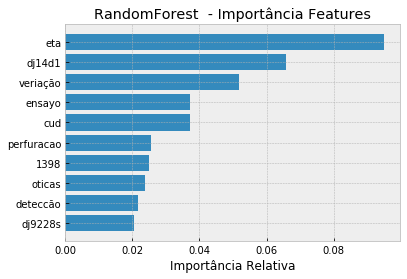

In [13]:
plt.figure(figsize=(6,4))

nshow = 10
model_name = 'RandomForest'
model = model_list[model_name].best_estimator_.steps[1][1]
vocabulary = model_list[model_name].best_estimator_.steps[0][1].vocabulary_
vocabulary = np.array(list(vocabulary.keys()))

coefs = model.feature_importances_

idx = np.argsort(np.abs(coefs))[-nshow:]

yaxis = np.arange(nshow)


plt.barh(yaxis, coefs[idx])
plt.yticks(yaxis, vocabulary[idx])

plt.title(model_name + '  - Importância Features')

plt.xlabel('Importância Relativa')

### <span style="color:MediumSlateBlue"> **9.Exportação do Resultado** </span>

In [14]:
model_name = 'LogisticRegr'

test_data = [Xtest, Ytest,]
df_cols = ['text', 'class'] 
for model_name in model_dict.keys():
    model = model_list[model_name]
    if model_name in ['RandomForest', 'SVM']:
        final_model = LogisticRegressionCV(Cs=20,cv=5)
        if model_name == 'SVM':
            Yhat_train = model.decision_function(Xtrain)
            Yhat = model.decision_function(Xtest)
        else:
            Yhat_train = model.predict_proba(Xtrain)[:,1]
            Yhat = model.predict_proba(Xtest)[:,1]
            
        final_model.fit(Yhat_train.reshape(-1, 1), Ytrain)
        Yhat  = final_model.predict_proba(Yhat.reshape(-1,1))[:,1]
    else:
        Yhat = model.predict_proba(Xtest)[:,1]

    test_data.append(Yhat)
    df_cols.append(model_name)
        
test_data = np.array(test_data).T
df_test = pd.DataFrame(data=test_data, columns=df_cols)

df_test.to_excel('../../Data/Modeling/results.xlsx')

df_test.head()

,text,class,RandomForest,LogisticRegr,kNN,SVM
0,REALIZAR TESTES PONTO-A-PONTO COM O ONS,False,0.40014945605628516,0.6220992172301747,0.3871165070110641,0.2858912768103344
1,COLOCAR ESFÉRAS DE SINALIZAÇÃO AÉREA,True,0.6377014154773304,0.9729507333741643,1.0,0.5496463115916804
2,REVISÃO GERAL NA SECCIONADORA 751.,False,0.40014945605628516,0.36674980341848834,0.5833066313955533,0.5882115485551436
3,MANUTENÇÃO CORRETIVA DA UTR. DEVIDO A PROBLEMA...,False,0.40014945605628516,0.021485340185561867,0.11283831039819053,0.2443180639600465
4,MANUTENÇÃO PREVENTIVA DA LINHA DE CARVÃO PULV...,True,0.6631733235471163,0.9856583473262293,1.0,0.7394794129920167
